# Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import shutil
import os

src_dir = '/content/drive/MyDrive/counting_project/counting_dataset'
dst_dir = '/content/counting_dataset'

# Make sure destination directory exists
os.makedirs(dst_dir, exist_ok=True)

# Loop through all files in source directory
for filename in os.listdir(src_dir):
    src_file = os.path.join(src_dir, filename)
    dst_file = os.path.join(dst_dir, filename)

    # Only copy files (skip subdirectories)
    if os.path.isfile(src_file):
        shutil.copy2(src_file, dst_file)  # copy2 preserves metadata

# Benchmark

In [ ]:
"""
Modularized script for benchmarking multiple LLMs on a counting task.
This script evaluates how well different models can count items of a specific type
in a list without using reasoning tokens (zero-shot).
"""

import transformers
import torch
import csv
import re
import pandas as pd
from tqdm import tqdm
from abc import ABC, abstractmethod
from typing import Dict, List, Any, Optional
import logging
from datetime import datetime
import os
import warnings
warnings.filterwarnings("ignore")

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)


class ModelBenchmark(ABC):
    """Abstract base class for model benchmarks"""

    def __init__(self, model_name: str, output_suffix: str, token: Optional[str] = None):
        self.model_name = model_name
        self.output_suffix = output_suffix
        self.token = token
        self.model = None
        self.tokenizer = None
        self.processor = None

    @abstractmethod
    def load_model(self, **kwargs):
        """Load the model and tokenizer/processor"""
        pass

    @abstractmethod
    def generate_response(self, messages: List[Dict[str, str]], **kwargs) -> str:
        """Generate response from the model"""
        pass

    def cleanup(self):
        """Clean up model from memory"""
        if hasattr(self, 'model') and self.model is not None:
            del self.model
        if hasattr(self, 'tokenizer') and self.tokenizer is not None:
            del self.tokenizer
        if hasattr(self, 'processor') and self.processor is not None:
            del self.processor
        if hasattr(self, 'pipeline') and self.pipeline is not None:
            del self.pipeline

        # Aggressive GPU memory cleanup
        import gc
        gc.collect()
        torch.cuda.empty_cache()
        if torch.cuda.is_available():
            torch.cuda.synchronize()
            torch.cuda.reset_peak_memory_stats()

        logger.info(f"Cleaned up {self.model_name} from memory")


class LlamaModel(ModelBenchmark):
    """Llama model implementation"""

    def load_model(self, **kwargs):
        logger.info(f"Loading {self.model_name}...")
        self.pipeline = transformers.pipeline(
            "text-generation",
            model=self.model_name,
            device_map="auto",
            token=self.token,  # Use the token passed during initialization
        )

    def generate_response(self, messages: List[Dict[str, str]], **kwargs) -> str:
        outputs = self.pipeline(
            messages,
            max_new_tokens=5,
            # temperature=0.0,
            do_sample=False,
            pad_token_id=self.pipeline.tokenizer.eos_token_id
        )
        return outputs[0]["generated_text"][-1]["content"]


class PhiModel(ModelBenchmark):
    """Phi model implementation"""

    def load_model(self, **kwargs):
        logger.info(f"Loading {self.model_name}...")
        self.pipeline = transformers.pipeline(
            "text-generation",
            model=self.model_name,
            model_kwargs={"torch_dtype": "auto"},
            device_map="auto",
        )

    def generate_response(self, messages: List[Dict[str, str]], **kwargs) -> str:
        outputs = self.pipeline(
            messages,
            max_new_tokens=5,
            # temperature=0.0,
            do_sample=False,
            pad_token_id=self.pipeline.tokenizer.eos_token_id
        )
        return outputs[0]["generated_text"][-1]["content"]


class GemmaModel(ModelBenchmark):
    """Gemma model implementation"""

    def load_model(self, **kwargs):
        logger.info(f"Loading {self.model_name}...")
        from transformers import AutoProcessor, Gemma3ForConditionalGeneration

        self.model = Gemma3ForConditionalGeneration.from_pretrained(
            self.model_name,
            device_map="auto",
            token=self.token,  # Use the token passed during initialization
        ).eval()
        self.processor = AutoProcessor.from_pretrained(self.model_name, token=self.token)

    def generate_response(self, messages: List[Dict[str, str]], **kwargs) -> str:
        # Convert messages to Gemma format
        gemma_messages = []
        for msg in messages:
            gemma_messages.append({
                "role": msg["role"],
                "content": [{"type": "text", "text": msg["content"]}]
            })

        inputs = self.processor.apply_chat_template(
            gemma_messages,
            add_generation_prompt=True,
            tokenize=True,
            return_dict=True,
            return_tensors="pt"
        ).to(self.model.device, dtype=torch.bfloat16)

        input_len = inputs["input_ids"].shape[-1]

        with torch.inference_mode():
            generation = self.model.generate(
                **inputs,
                max_new_tokens=1000,
                do_sample=False,
                pad_token_id=self.processor.tokenizer.eos_token_id,
            )
            generation = generation[0][input_len:]

        return self.processor.decode(generation, skip_special_tokens=True)


class QwenModel(ModelBenchmark):
    """Qwen model implementation"""

    def load_model(self, **kwargs):
        logger.info(f"Loading {self.model_name}...")
        from transformers import AutoTokenizer, AutoModelForCausalLM

        self.tokenizer = AutoTokenizer.from_pretrained(self.model_name)
        self.model = AutoModelForCausalLM.from_pretrained(
            self.model_name,
            torch_dtype="auto",
            device_map="auto"
        )

    def generate_response(self, messages: List[Dict[str, str]], **kwargs) -> str:
        text = self.tokenizer.apply_chat_template(
            messages,
            tokenize=False,
            add_generation_prompt=True,
            enable_thinking=False
        )

        model_inputs = self.tokenizer([text], return_tensors="pt").to(self.model.device)

        with torch.no_grad():
            generated_ids = self.model.generate(
                **model_inputs,
                max_new_tokens=5,
                # temperature=0.0,
                do_sample=False,
                pad_token_id=self.tokenizer.eos_token_id
            )

        output_ids = generated_ids[0][len(model_inputs.input_ids[0]):].tolist()
        return self.tokenizer.decode(output_ids, skip_special_tokens=True).strip("\n")


class CountingBenchmark:
    """Main benchmark class for evaluating models on counting task"""

    def __init__(self, dataset_path: str, output_dir: str = "/content/counting_dataset/"):
        self.dataset_path = dataset_path
        self.output_dir = output_dir
        self.dataset = self.load_dataset()

    def load_dataset(self) -> List[Dict[str, Any]]:
        """Load the counting dataset"""
        logger.info(f"Loading dataset from {self.dataset_path}")
        data = []
        with open(self.dataset_path, 'r') as f:
            reader = csv.DictReader(f)
            for row in reader:
                list_items = eval(row['list_items']) if isinstance(row['list_items'], str) else row['list_items']
                data.append({
                    'type': row['type'],
                    'list_items': list_items,
                    'list_length': int(row['list_length']),
                    'answer': int(row['answer'])
                })
        logger.info(f"Loaded {len(data)} examples")
        return data

    @staticmethod
    def extract_model_answer(generated_text: str) -> int:
        """Extract the numerical answer from model's response"""
        text = generated_text.strip()

        # Look for exact pattern (number)
        match = re.search(r'\((\d+)\)', text)
        if match:
            return int(match.group(1))

        # If no parentheses, look for just a number
        match = re.search(r'^\s*(\d+)\s*$', text)
        if match:
            return int(match.group(1))

        # If still nothing, look for any number in the text
        match = re.search(r'(\d+)', text)
        if match:
            return int(match.group(1))

        logger.warning(f"Could not extract answer from: '{text}'")
        return -1

    def create_prompt(self, example: Dict[str, Any]) -> str:
        """Create the prompt for the model"""
        return f"""Count how many words in this list match the type "{example['type']}".

List: {example['list_items']}

Respond with only the number in parentheses, like (0), (1), (2), etc."""

    def create_messages(self, prompt: str) -> List[Dict[str, str]]:
        """Create the messages for the model"""
        return [
            {
                "role": "system",
                "content": "You are a precise counting assistant. When given a list and a type, count how many items match that type. Always respond with ONLY the count in parentheses format: (0), (1), (2), etc. Never include explanations or other text."
            },
            {"role": "user", "content": prompt}
        ]

    def benchmark_model(self, model: ModelBenchmark, num_examples: Optional[int] = None,
                       save_intermediate: bool = True) -> pd.DataFrame:
        """Benchmark a single model"""
        results = []
        num_examples = num_examples or len(self.dataset)
        num_examples = min(num_examples, len(self.dataset))

        logger.info(f"Benchmarking {model.model_name} on {num_examples} examples...")

        for i in tqdm(range(num_examples), desc=f"Processing {model.model_name}"):
            example = self.dataset[i]

            # Create prompt and messages
            prompt = self.create_prompt(example)
            messages = self.create_messages(prompt)

            try:
                # Generate response
                model_response = model.generate_response(messages)

                # Extract answer
                extracted_answer = self.extract_model_answer(model_response)

                # Store results
                results.append({
                    'type': example['type'],
                    'list_items': str(example['list_items']),
                    'list_length': example['list_length'],
                    'expected_answer': example['answer'],
                    'model_full_response': model_response,
                    'extracted_model_answer': extracted_answer,
                    'correct': extracted_answer == example['answer']
                })

                # Print progress every 10 examples
                if (i + 1) % 10 == 0:
                    accuracy = sum(r['correct'] for r in results) / len(results)
                    logger.info(f"Processed {i+1} examples. Current accuracy: {accuracy:.2%}")

            except Exception as e:
                logger.error(f"Error processing example {i}: {str(e)}")
                results.append({
                    'type': example['type'],
                    'list_items': str(example['list_items']),
                    'list_length': example['list_length'],
                    'expected_answer': example['answer'],
                    'model_full_response': f"ERROR: {str(e)}",
                    'extracted_model_answer': -1,
                    'correct': False
                })

        # Create DataFrame
        df = pd.DataFrame(results)

        # Save results
        if save_intermediate:
            output_path = os.path.join(self.output_dir, f"{model.output_suffix}_results.csv")
            df.to_csv(output_path, index=False)
            logger.info(f"Results saved to: {output_path}")

        # Print summary
        accuracy = df['correct'].mean()
        logger.info(f"\n{model.model_name} Results:")
        logger.info(f"Overall accuracy: {accuracy:.2%}")
        logger.info(f"Total examples processed: {len(results)}")

        # Show accuracy by type
        type_accuracy = df.groupby('type')['correct'].agg(['mean', 'count'])
        logger.info(f"\nAccuracy by type:\n{type_accuracy}")

        return df

    def run_all_benchmarks(self, models: List[ModelBenchmark], num_examples: Optional[int] = None) -> pd.DataFrame:
        """Run benchmarks for all models and create comparison"""
        all_results = {}

        for model in models:
            try:
                # Load model
                if hasattr(model, 'load_model'):
                    model.load_model()

                # Run benchmark
                df = self.benchmark_model(model, num_examples)
                all_results[model.model_name] = df

                # Clean up to save memory - more aggressive cleanup
                model.cleanup()

                # Additional cleanup between models
                import gc
                gc.collect()
                torch.cuda.empty_cache()
                if torch.cuda.is_available():
                    logger.info(f"GPU memory after {model.model_name}: {torch.cuda.memory_allocated()/1024**3:.2f} GB")

                # Small delay to ensure cleanup
                import time
                time.sleep(2)

            except Exception as e:
                logger.error(f"Failed to benchmark {model.model_name}: {str(e)}")

        # Create comparison summary
        comparison_data = []
        for model_name, df in all_results.items():
            comparison_data.append({
                'model': model_name,
                'overall_accuracy': df['correct'].mean(),
                'total_examples': len(df),
                'correct_count': df['correct'].sum()
            })

        comparison_df = pd.DataFrame(comparison_data)
        comparison_df = comparison_df.sort_values('overall_accuracy', ascending=False)

        # Save comparison
        comparison_path = os.path.join(self.output_dir, "model_comparison.csv")
        comparison_df.to_csv(comparison_path, index=False)

        logger.info(f"\n\nFinal Comparison:\n{comparison_df}")
        logger.info(f"\nComparison saved to: {comparison_path}")

        return comparison_df


def main():
    """Main function to run the benchmark"""

    # Get tokens from Google Colab userdata
    try:
        from google.colab import userdata
        hf_meta_token = userdata.get('HF_Meta')
        hf_token = userdata.get('HF_TOKEN')
        logger.info("Successfully loaded tokens from Google Colab userdata")
    except Exception as e:
        logger.warning(f"Could not load tokens from Google Colab: {e}")
        hf_meta_token = None
        hf_token = None

    # Configuration
    dataset_path = "/content/counting_dataset/counting_dataset_5000.csv"
    output_dir = "/content/counting_dataset/"
    num_examples = 1000  # Adjust as needed

    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Define models to benchmark with their required tokens
    # Removed GemmaModel due to disk space constraints
    models = [
        LlamaModel("meta-llama/Meta-Llama-3.1-8B-Instruct", "llama3_1_8b", token=hf_meta_token),
        PhiModel("microsoft/phi-4", "phi4"),
        QwenModel("Qwen/Qwen3-8B", "qwen3_8b")
    ]

    # Create benchmark instance
    benchmark = CountingBenchmark(dataset_path, output_dir)

    # Run all benchmarks
    start_time = datetime.now()
    comparison_df = benchmark.run_all_benchmarks(models, num_examples=num_examples)
    end_time = datetime.now()

    logger.info(f"\nTotal benchmark time: {end_time - start_time}")

    # Optional: Create a detailed comparison report
    create_detailed_report(output_dir, models)


def create_detailed_report(output_dir: str, models: List[ModelBenchmark]):
    """Create a detailed comparison report"""

    report_lines = ["# LLM Counting Task Benchmark Report\n"]
    report_lines.append(f"Generated on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")

    # Load all results
    all_dfs = {}
    for model in models:
        result_path = os.path.join(output_dir, f"{model.output_suffix}_results.csv")
        if os.path.exists(result_path):
            all_dfs[model.model_name] = pd.read_csv(result_path)

    # Overall comparison
    report_lines.append("## Overall Performance\n")
    for model_name, df in all_dfs.items():
        accuracy = df['correct'].mean()
        report_lines.append(f"- **{model_name}**: {accuracy:.2%} accuracy\n")

    # Performance by type
    report_lines.append("\n## Performance by Type\n")
    type_performances = {}
    for model_name, df in all_dfs.items():
        type_acc = df.groupby('type')['correct'].mean()
        type_performances[model_name] = type_acc

    if type_performances:
        type_df = pd.DataFrame(type_performances)
        report_lines.append(type_df.to_string())

    # Save report
    report_path = os.path.join(output_dir, "benchmark_report.md")
    with open(report_path, 'w') as f:
        f.writelines(report_lines)

    logger.info(f"\nDetailed report saved to: {report_path}")

if __name__ == "__main__":
    main()

Processing Qwen/Qwen3-8B: 100%|██████████| 1000/1000 [03:52<00:00,  4.29it/s]


# plot

Loading model results...
Loaded 1000 results for Llama 3.1 8B
Loaded 1000 results for Phi-4
Loaded 1000 results for Qwen3 8B

Calculating accuracies...

OVERALL ACCURACIES:
Phi-4          : 65.5%
Qwen3 8B       : 40.0%
Llama 3.1 8B   : 31.9%

DETAILED COMPARISON TABLE:
       Model Overall Accuracy Animal Acc Body_part Acc Building Acc Clothing Acc Color Acc Emotion Acc Fruit Acc Sport Acc Tool Acc Vehicle Acc Weather Acc
       Phi-4            65.5%      73.4%         69.6%        32.9%        77.3%     71.9%       75.3%     94.2%     63.9%    60.9%       53.5%       48.2%
    Qwen3 8B            40.0%      45.7%         39.2%        25.3%        59.1%     39.3%       47.2%     57.0%     34.9%    31.5%       31.4%       30.4%
Llama 3.1 8B            31.9%      39.4%         51.0%        15.2%        37.5%     34.8%       40.4%     44.2%     24.1%    20.7%       17.4%       23.2%

Saved comparison table to /content/counting_dataset/accuracy_comparison_table.csv

Creating visualization

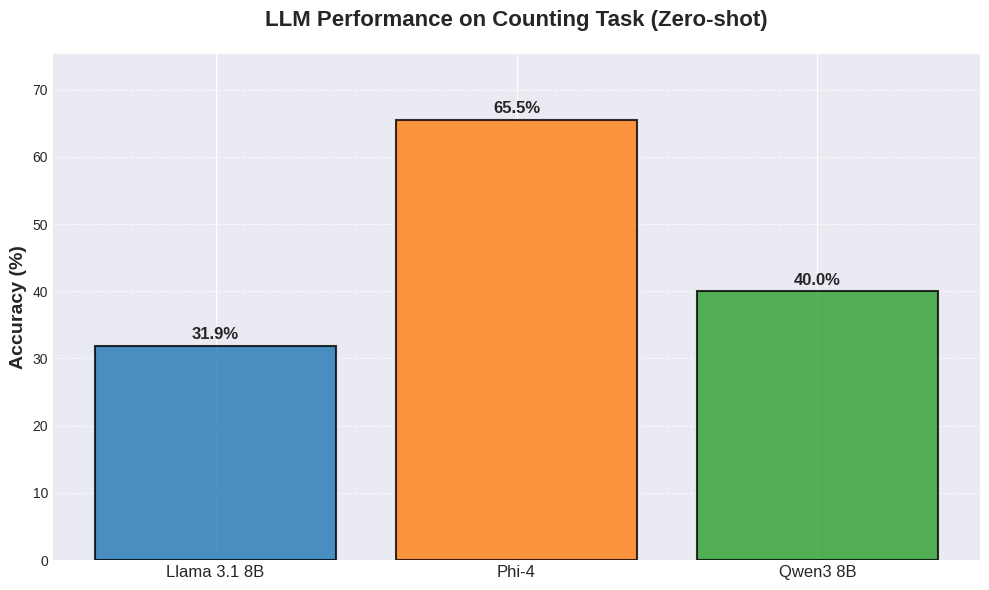

Saved plot to /content/counting_dataset/type_accuracy_comparison.png


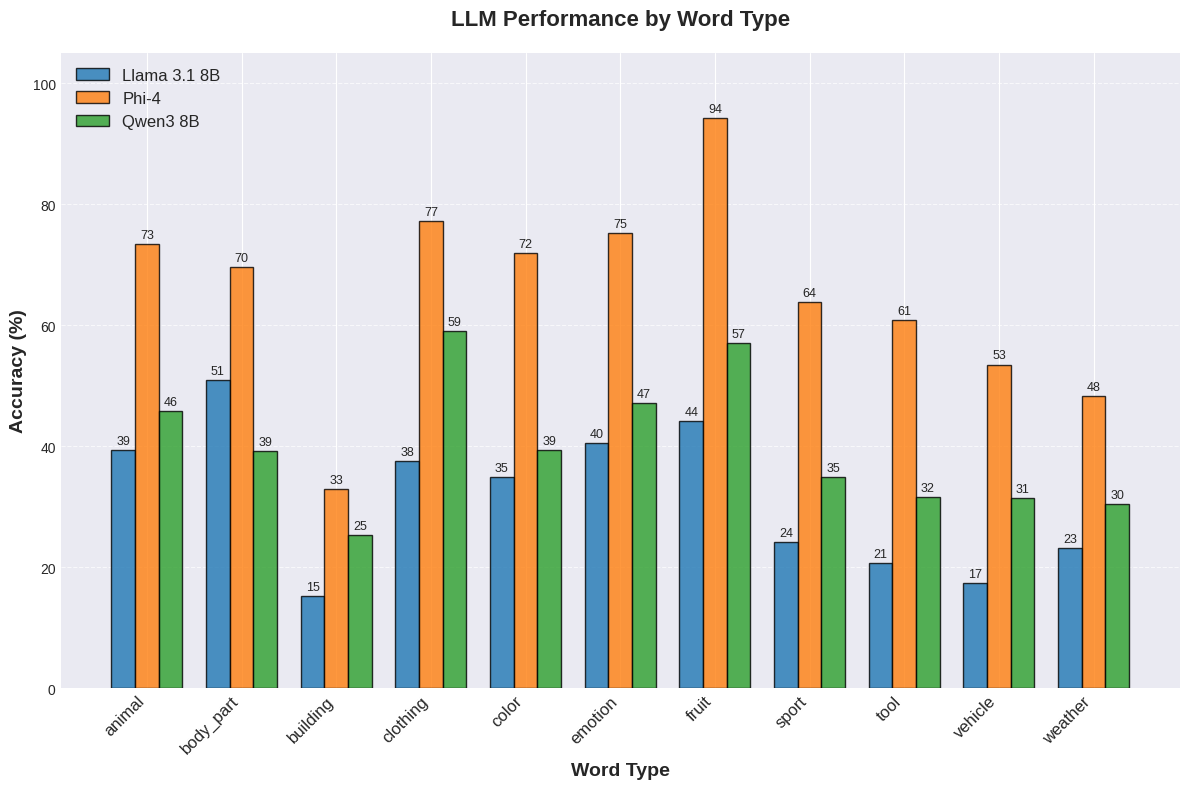


All visualizations created successfully!


In [ ]:
"""
Script to plot the accuracy comparison of different LLMs on the counting task
"""

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pathlib import Path

def load_model_results(result_dir="/content/counting_dataset/"):
    """Load results from CSV files for each model"""

    models_info = [
        ("llama3_1_8b_results.csv", "Llama 3.1 8B"),
        ("phi4_results.csv", "Phi-4"),
        ("qwen3_8b_results.csv", "Qwen3 8B")
    ]

    results = {}

    for filename, model_name in models_info:
        filepath = Path(result_dir) / filename
        if filepath.exists():
            df = pd.read_csv(filepath)
            results[model_name] = df
            print(f"Loaded {len(df)} results for {model_name}")
        else:
            print(f"Warning: Could not find {filepath}")

    return results

def calculate_accuracies(results):
    """Calculate overall and per-type accuracies for each model"""

    accuracies = {}

    for model_name, df in results.items():
        # Overall accuracy
        overall_acc = df['correct'].mean() * 100

        # Per-type accuracy
        type_accs = df.groupby('type')['correct'].mean() * 100

        accuracies[model_name] = {
            'overall': overall_acc,
            'by_type': type_accs.to_dict()
        }

    return accuracies

def plot_overall_comparison(accuracies, save_path=None):
    """Create a bar plot comparing overall accuracies"""

    # Set style
    plt.style.use('seaborn-v0_8-darkgrid')

    # Extract data
    models = list(accuracies.keys())
    overall_accs = [accuracies[model]['overall'] for model in models]

    # Create figure
    fig, ax = plt.subplots(figsize=(10, 6))

    # Create bars
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Blue, Orange, Green
    bars = ax.bar(models, overall_accs, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)

    # Add value labels on bars
    for bar, acc in zip(bars, overall_accs):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{acc:.1f}%', ha='center', va='bottom', fontsize=12, fontweight='bold')

    # Customize plot
    ax.set_ylabel('Accuracy (%)', fontsize=14, fontweight='bold')
    ax.set_title('LLM Performance on Counting Task (Zero-shot)', fontsize=16, fontweight='bold', pad=20)
    ax.set_ylim(0, max(overall_accs) * 1.15)  # Add some space at the top

    # Add grid
    ax.yaxis.grid(True, linestyle='--', alpha=0.7)
    ax.set_axisbelow(True)

    # Customize x-axis
    ax.set_xticklabels(models, fontsize=12)

    # Add legend
    ax.legend(loc='upper right')

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved plot to {save_path}")

    plt.show()

    return fig, ax

def plot_type_comparison(accuracies, save_path=None):
    """Create a grouped bar plot comparing accuracies by type"""

    # Prepare data
    all_types = set()
    for model_data in accuracies.values():
        all_types.update(model_data['by_type'].keys())
    all_types = sorted(all_types)

    models = list(accuracies.keys())

    # Create data matrix
    data = []
    for type_name in all_types:
        type_data = []
        for model in models:
            acc = accuracies[model]['by_type'].get(type_name, 0)
            type_data.append(acc)
        data.append(type_data)

    # Create figure
    fig, ax = plt.subplots(figsize=(12, 8))

    # Set bar positions
    x = np.arange(len(all_types))
    width = 0.25

    # Create bars for each model
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    for i, (model, color) in enumerate(zip(models, colors)):
        positions = x + (i - 1) * width
        values = [row[i] for row in data]
        bars = ax.bar(positions, values, width, label=model, color=color, alpha=0.8, edgecolor='black', linewidth=1)

        # Add value labels
        for bar, val in zip(bars, values):
            if val > 0:  # Only show label if there's a value
                ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.5,
                       f'{val:.0f}', ha='center', va='bottom', fontsize=9)

    # Customize plot
    ax.set_ylabel('Accuracy (%)', fontsize=14, fontweight='bold')
    ax.set_xlabel('Word Type', fontsize=14, fontweight='bold')
    ax.set_title('LLM Performance by Word Type', fontsize=16, fontweight='bold', pad=20)
    ax.set_xticks(x)
    ax.set_xticklabels(all_types, fontsize=12, rotation=45, ha='right')
    ax.legend(fontsize=12, loc='upper left')
    ax.set_ylim(0, 105)

    # Add grid
    ax.yaxis.grid(True, linestyle='--', alpha=0.7)
    ax.set_axisbelow(True)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved plot to {save_path}")

    plt.show()

    return fig, ax

def create_comparison_table(accuracies):
    """Create a comparison table of results"""

    # Create DataFrame
    data = []
    for model, accs in accuracies.items():
        row = {'Model': model, 'Overall Accuracy': f"{accs['overall']:.1f}%"}
        for type_name, acc in sorted(accs['by_type'].items()):
            row[f'{type_name.capitalize()} Acc'] = f"{acc:.1f}%"
        data.append(row)

    df = pd.DataFrame(data)

    # Sort by overall accuracy
    df['_sort_key'] = df['Overall Accuracy'].str.rstrip('%').astype(float)
    df = df.sort_values('_sort_key', ascending=False).drop('_sort_key', axis=1)

    return df

def main():
    """Main function to create all visualizations"""

    # Configuration
    result_dir = "/content/counting_dataset/"
    output_dir = "/content/counting_dataset/"

    # Load results
    print("Loading model results...")
    results = load_model_results(result_dir)

    if not results:
        print("No results found! Please check the result directory.")
        return

    # Calculate accuracies
    print("\nCalculating accuracies...")
    accuracies = calculate_accuracies(results)

    # Print summary
    print("\n" + "="*50)
    print("OVERALL ACCURACIES:")
    print("="*50)
    for model, accs in sorted(accuracies.items(), key=lambda x: x[1]['overall'], reverse=True):
        print(f"{model:15s}: {accs['overall']:.1f}%")

    # Create comparison table
    print("\n" + "="*50)
    print("DETAILED COMPARISON TABLE:")
    print("="*50)
    comparison_df = create_comparison_table(accuracies)
    print(comparison_df.to_string(index=False))

    # Save comparison table
    table_path = Path(output_dir) / "accuracy_comparison_table.csv"
    comparison_df.to_csv(table_path, index=False)
    print(f"\nSaved comparison table to {table_path}")

    # Create visualizations
    print("\nCreating visualizations...")

    # Overall comparison plot
    overall_plot_path = Path(output_dir) / "overall_accuracy_comparison.png"
    plot_overall_comparison(accuracies, save_path=overall_plot_path)

    # Type comparison plot
    type_plot_path = Path(output_dir) / "type_accuracy_comparison.png"
    plot_type_comparison(accuracies, save_path=type_plot_path)

    print("\nAll visualizations created successfully!")

if __name__ == "__main__":
    main()

# save data

In [ ]:
import shutil
import os

src_dir = '/content/counting_dataset'
dst_dir = '/content/drive/MyDrive/counting_project/counting_dataset'

# Make sure destination directory exists
os.makedirs(dst_dir, exist_ok=True)

# Loop through all files in source directory
for filename in os.listdir(src_dir):
    src_file = os.path.join(src_dir, filename)
    dst_file = os.path.join(dst_dir, filename)

    # Only copy files (skip subdirectories)
    if os.path.isfile(src_file):
        shutil.copy2(src_file, dst_file)  # copy2 preserves metadata

# end